In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import glob

In [ ]:
import os

In [4]:
# !pip install matplotlib

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
from collections import defaultdict

In [7]:
import re

In [8]:
def get_metadata(lines):
    
    def get_meta(line, exp):
        m = re.match(fr"^{exp}\s*=\s*(.*)", line)
        return m.group(1) if m else None
    
    metadata = {k:None for k in ["CONCURRENCY", "BUFFER_SIZE", "MULTI_THREAD_CUTOFF", "MULTI_THREAD_STREAMS"]}
    for k  in metadata.keys():
        for line in lines:
            m = get_meta(line, k)
            if m and not metadata[k]:
                metadata[k] = m
                break
    return metadata

def get_rate_texts(texts):
    res = []
    for text in texts:
        m = re.match(r"Transferred:.*ETA.*",  text)
        if m:
            res.append(m.group())
    return res

def parse_rate(text):
    m = re.match(r"Transferred:.*%,.(\d+(?:\.\d+)?)\s+(MiB|B)\/s", text)
    return m.group(1) if m else None

def parse_source_dest(text):
    m = re.match(r".*Executing.*rclone.*copy\s+([A-Za-z0-9-+:\/]+)\s+([A-Za-z0-9-+:\/]+).*--config.*", text)
    return (m.group(1), m.group(2)) if m else None

def parse_log(filename):
    with open(filename) as f:
        lines = f.readlines()
        lines = map(str.strip, lines)
        lines = filter(lambda l: len(l)>0, lines)
        lines = list(lines)
        
        metadata = get_metadata(lines[:20])
        
        src_dest = parse_source_dest(" ".join(lines))
        if src_dest and len(src_dest)==2:
            metadata["src"] = src_dest[0]
            metadata["dest"] = src_dest[1]
        
        rate_lines = get_rate_texts(lines)
        
        rates = map(parse_rate, rate_lines)
        rates = filter(None, rates)
        rates = map(float, rates)
        rates = list(rates)
        return metadata, rates

In [9]:
# filename = "logs/2022-02-23.11:26.log"
# filename = "logs/2022-02-16.12:46.log"

In [10]:
# METADATA, RATES = parse_log(filename)

In [11]:
# len(RATES), METADATA

In [12]:
def plot_rates(rates, metadata=None):
    metadata = metadata or {}
    plt.plot(rates)

In [13]:
def plot_bulk(logdir="logs/"):
    filenames = glob.glob(os.path.join(logdir, "*.log"))
    plt.figure(figsize=(30, 20))
    tracker = []
    for fname in filenames:
        meta, rates = parse_log(fname)
        if not meta or len(rates) < 10:
            continue
        plot_rates(rates, meta)
        tracker.append(", ".join([str(v) for v in meta.values() if v]))
    plt.legend(tracker)
    plt.xlabel("Time")
    plt.ylabel("Rate(MiBps)")

In [14]:
# plot_rates(RATES)

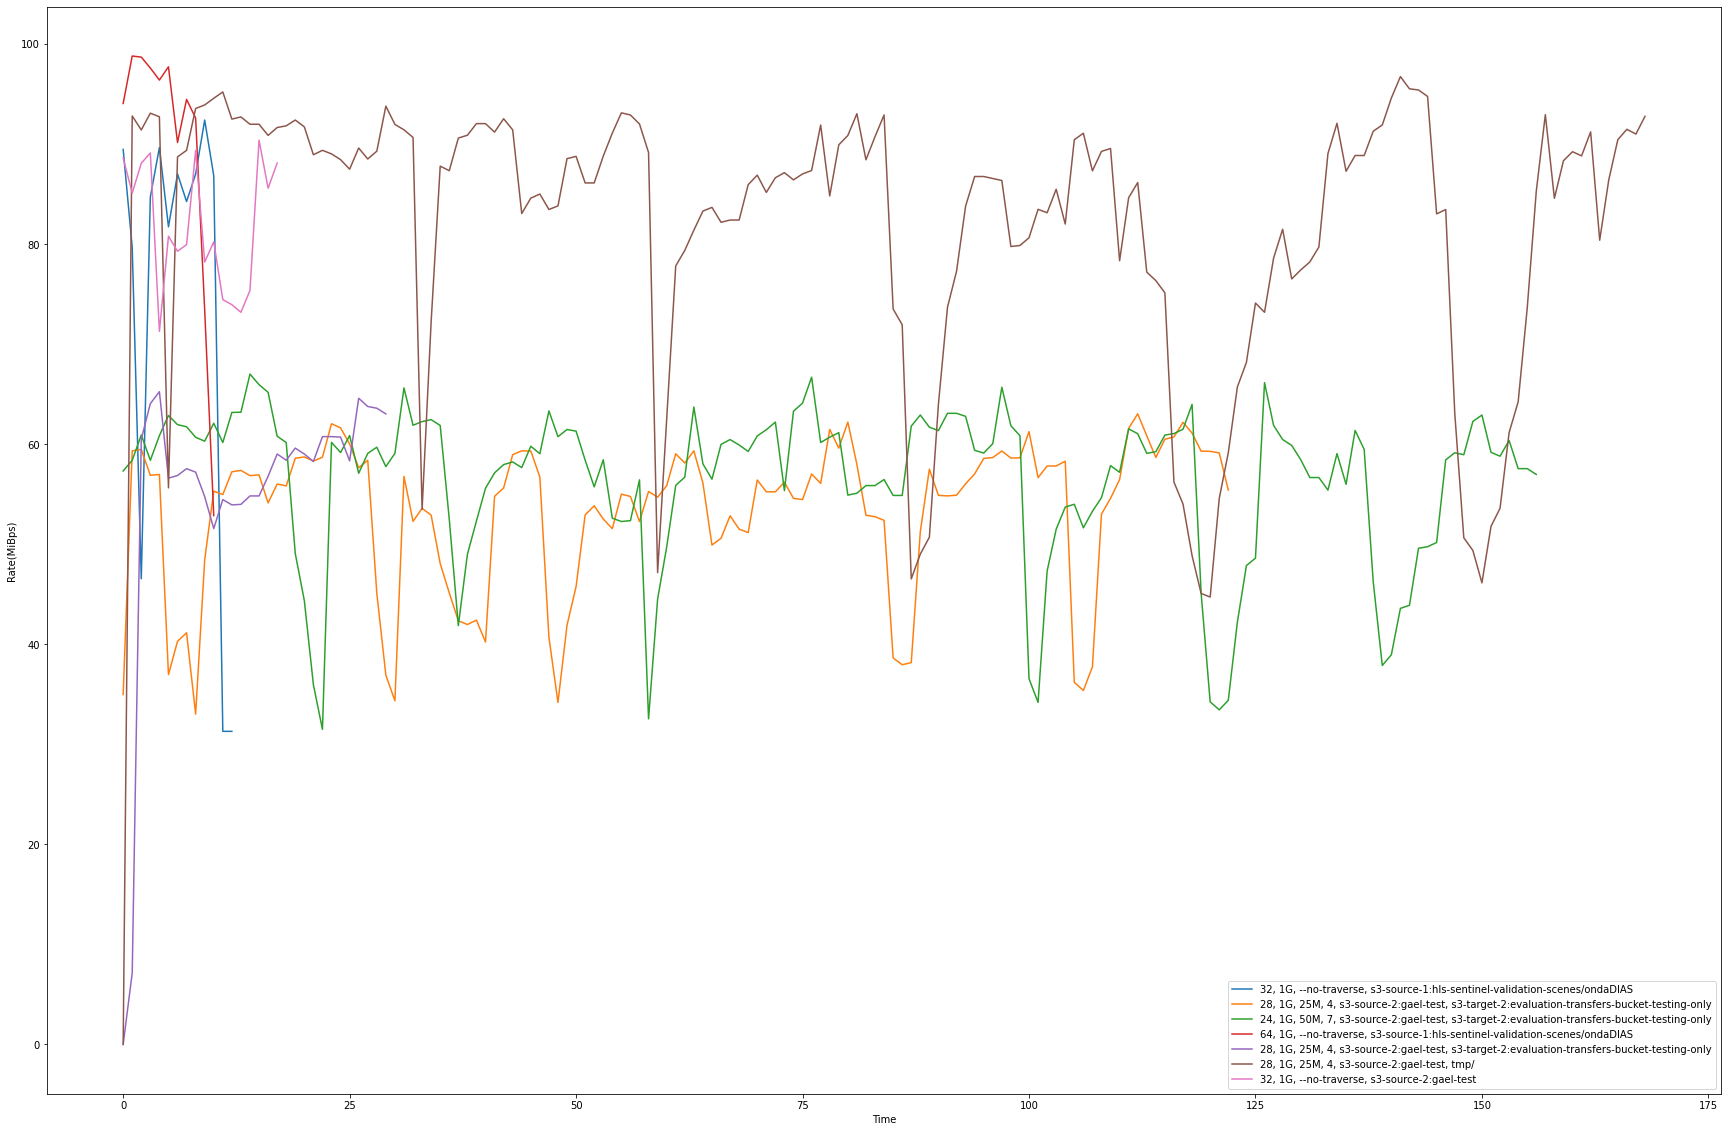

In [15]:
plot_bulk()